In [10]:
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install tslearn
!pip install boto3

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from sklearn.metrics import silhouette_score
from tslearn.clustering import TimeSeriesKMeans
from matplotlib.ticker import MultipleLocator
from io import StringIO

In [16]:
s3=boto3.client('s3')
response = s3.list_objects_v2(Bucket='pisemestre1', Prefix='trusted/2024_05')
for obj in response.get('Contents', []):
    key = obj['Key']
    if key.endswith('.csv'):
        print(key)
        csv_obj = s3.get_object(Bucket='pisemestre1', Key=key)
        body = csv_obj['Body']
        csv_string = body.read().decode('latin1')
        data = StringIO(csv_string)
        df= pd.read_csv(data)


print(df)

trusted/2024_05/trusted.csv
                     FECHA      VALOR       std  \
0      2024-06-01 23:30:00   4.205000       NaN   
1      2024-06-02 00:00:00   6.943778  3.402133   
2      2024-06-02 00:30:00   4.787625  2.233302   
3      2024-06-02 01:00:00   5.470333  2.945582   
4      2024-06-02 01:30:00   5.398222  2.739277   
...                    ...        ...       ...   
50814  2024-06-08 21:30:00  11.142600  1.034964   
50815  2024-06-08 22:00:00  12.591500  1.059499   
50816  2024-06-08 22:30:00  12.610200  1.213520   
50817  2024-06-08 23:00:00  12.226000  1.326201   
50818  2024-06-08 23:30:00  10.867250  0.184567   

                                                 COL_KEY     DESTINO MEDIDA  \
0      IPv4_google.com_avg_9ee4257bdd83d0a117ed1154b6...  google.com    avg   
1      IPv4_google.com_avg_9ee4257bdd83d0a117ed1154b6...  google.com    avg   
2      IPv4_google.com_avg_9ee4257bdd83d0a117ed1154b6...  google.com    avg   
3      IPv4_google.com_avg_9ee4257bdd83d0a1

In [17]:


df = df[df['MEDIDA']=='avg']
df = df[df['DESTINO']=='google.com']


df = df[~df['DEVICE_NAME'].str.contains('aut-', case=False)]

df = df[~df['DEVICE_NAME'].str.contains('Claro', case=False)]

df['FECHA'] = pd.to_datetime(df['FECHA'])################################################################


prev_week_hour = df['FECHA'].max() - pd.Timedelta(hours=24*3)#######################################

df = df[df['FECHA'] > prev_week_hour]###########################################################


df = df[df['COL_KEY'].str.contains('IPv4', case=False)]


df = df[['FECHA', 'VALOR',
       'DEVICE_NAME']]

df = df.reset_index(drop = True)

df.head()


FECHA      VALOR                   DEVICE_NAME
0 2024-06-06 00:00:00   5.369111  centro-Libre-Sin-asignar_etb
1 2024-06-06 00:30:00   5.595125  centro-Libre-Sin-asignar_etb
2 2024-06-06 01:00:00   5.513222  centro-Libre-Sin-asignar_etb
3 2024-06-06 01:30:00   6.891444  centro-Libre-Sin-asignar_etb
4 2024-06-06 02:00:00  10.636333  centro-Libre-Sin-asignar_etb

In [18]:
df

FECHA      VALOR  \
0     2024-06-06 00:00:00   5.369111   
1     2024-06-06 00:30:00   5.595125   
2     2024-06-06 01:00:00   5.513222   
3     2024-06-06 01:30:00   6.891444   
4     2024-06-06 02:00:00  10.636333   
...                   ...        ...   
18265 2024-06-08 21:30:00  11.142600   
18266 2024-06-08 22:00:00  12.591500   
18267 2024-06-08 22:30:00  12.610200   
18268 2024-06-08 23:00:00  12.226000   
18269 2024-06-08 23:30:00  10.867250   

                                             DEVICE_NAME  
0                           centro-Libre-Sin-asignar_etb  
1                           centro-Libre-Sin-asignar_etb  
2                           centro-Libre-Sin-asignar_etb  
3                           centro-Libre-Sin-asignar_etb  
4                           centro-Libre-Sin-asignar_etb  
...                                                  ...  
18265  nor_olt-5800-03402_MA5800T_ont-huawei-hg8245h_...  
18266  nor_olt-5800-03402_MA5800T_ont-huawei-hg8245h_...  
18267  nor_olt-5800-03402_MA5800T_ont-huawei-hg8245h_...  
18268  nor_olt-5800-03402_MA5800T_ont-huawei-hg8245h_...  
18269  nor_olt-5800-03402_MA5800T_ont-huawei-hg8245h_...  

[18270 rows x 3 columns]

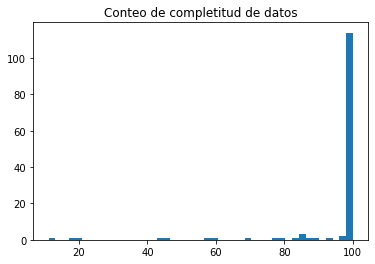

In [19]:
pivoted_df = df.pivot_table(values='VALOR', index='FECHA', columns='DEVICE_NAME', aggfunc='first')

analyzer =(pivoted_df.count(axis=0) / len(pivoted_df)) * 100

analyzer2 = analyzer.reset_index()

analyzer2['rounded_value'] = analyzer2[0].round(1)


plt.hist(analyzer2['rounded_value'],bins=45)
plt.title('Conteo de completitud de datos')
plt.show()

In [20]:
def filter_by_nan_ratio(df, nan_threshold=0.3):

  # Calculate the proportion of NaNs in each column
  nan_ratio = df.isna().mean(axis=0)

  # Filter columns based on the proportion of NaNs
  return df.loc[:, nan_ratio < nan_threshold]


pivoted_df = filter_by_nan_ratio(pivoted_df)

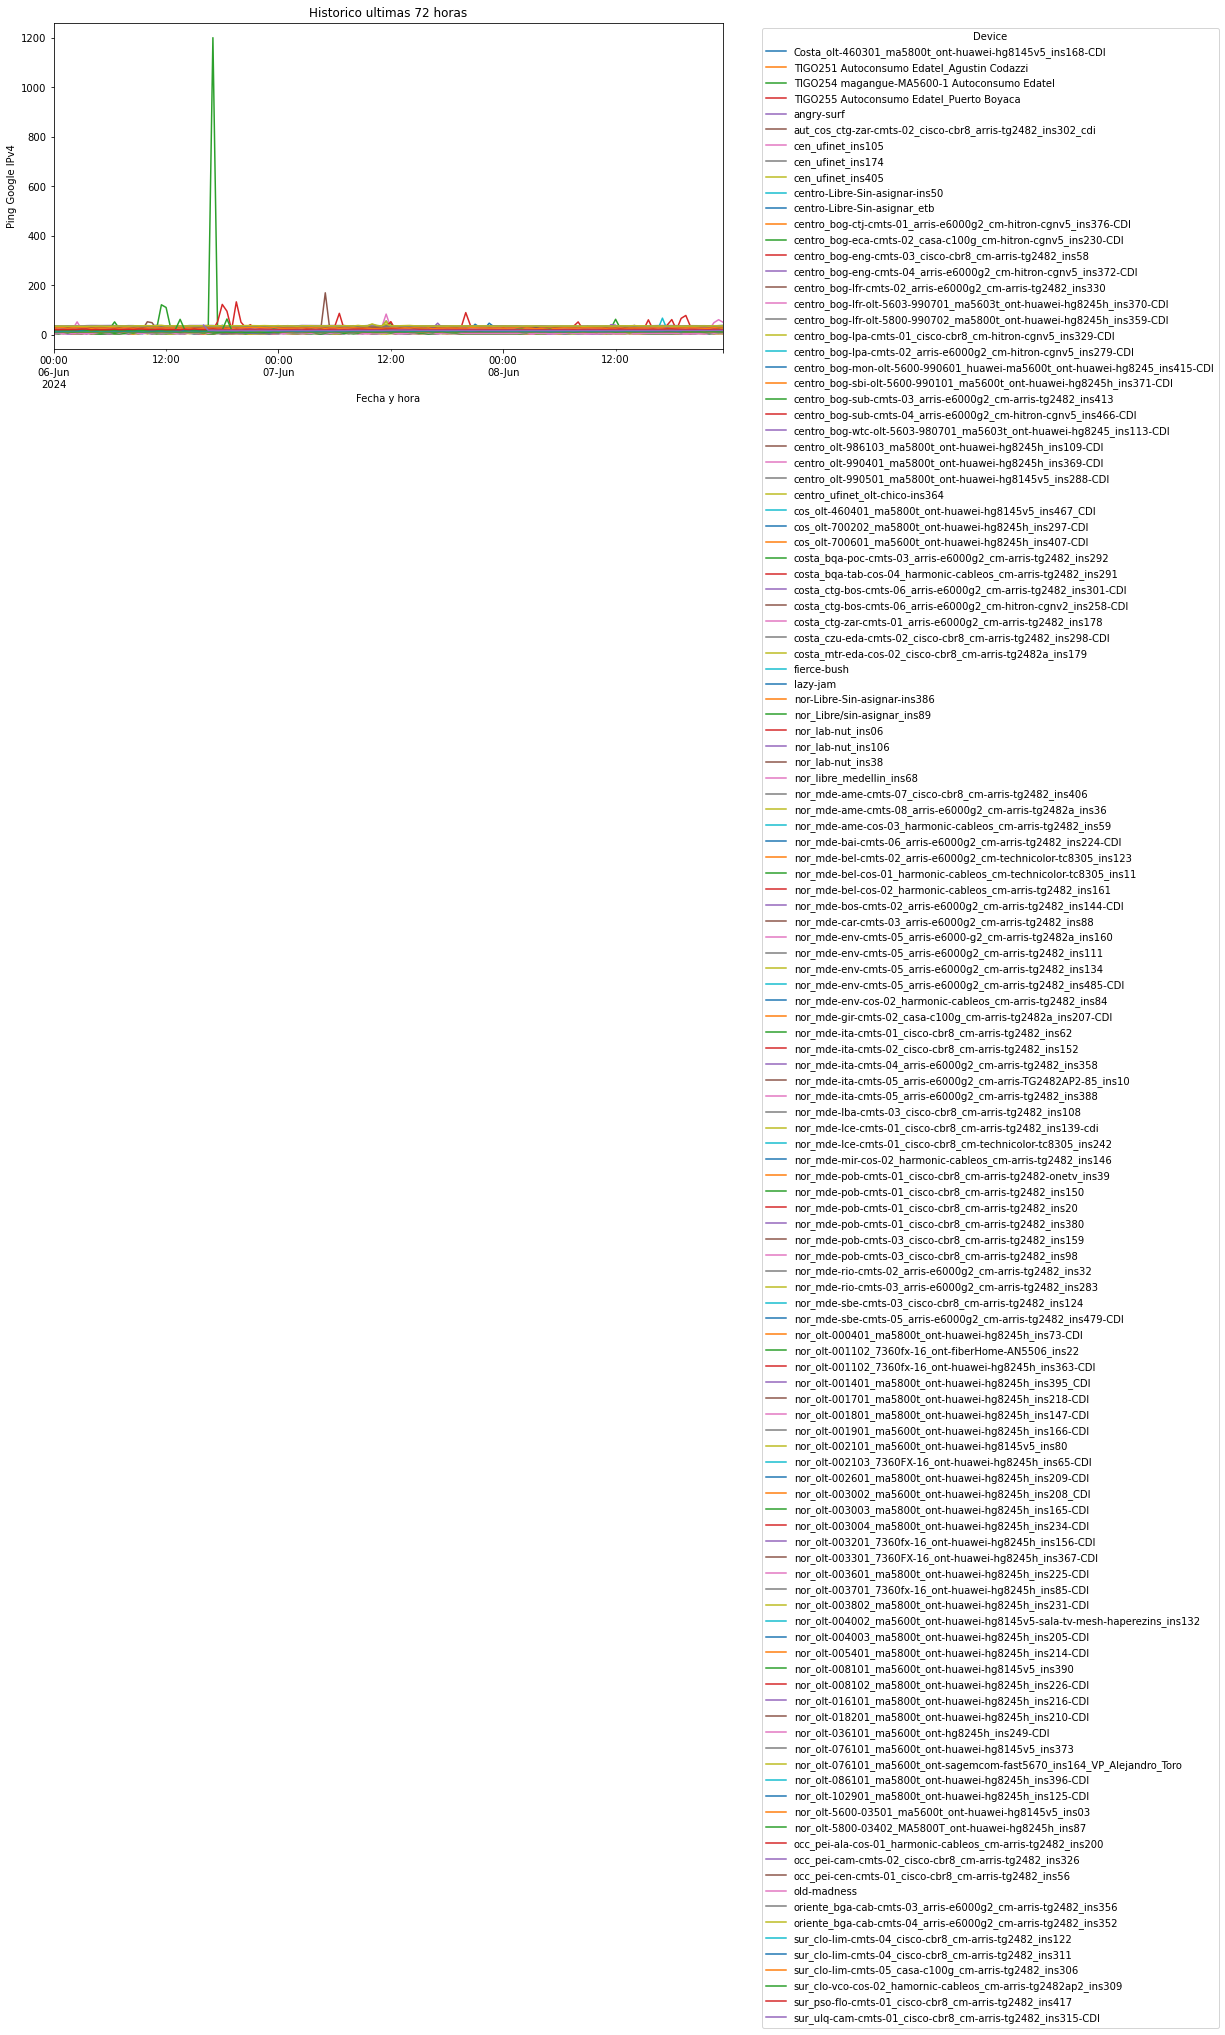

In [21]:
pivoted_df.plot(kind='line', figsize=(12, 6))  # Adjust figsize for better readability

# Optional: Customize the plot
plt.xlabel('Fecha y hora')  # Assuming your DataFrame has an index for time series
plt.ylabel('Ping Google IPv4')
plt.title('Historico ultimas 72 horas')

plt.legend(title='Device', bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.legend(title='Columns')  # Display a legend for each time series

plt.show()

In [22]:
pivoted_df

DEVICE_NAME          Costa_olt-460301_ma5800t_ont-huawei-hg8145v5_ins168-CDI  \
FECHA                                                                          
2024-06-06 00:00:00                                          18.167444         
2024-06-06 00:30:00                                          18.169000         
2024-06-06 01:00:00                                          18.124400         
2024-06-06 01:30:00                                          18.127111         
2024-06-06 02:00:00                                          18.247222         
...                                                                ...         
2024-06-08 21:30:00                                          18.284667         
2024-06-08 22:00:00                                          18.318667         
2024-06-08 22:30:00                                          18.323444         
2024-06-08 23:00:00                                          18.276556         
2024-06-08 23:30:00                                          18.314000         

DEVICE_NAME          TIGO251 Autoconsumo Edatel_Agustin Codazzi  \
FECHA                                                             
2024-06-06 00:00:00                                   22.256750   
2024-06-06 00:30:00                                   22.329667   
2024-06-06 01:00:00                                   22.252125   
2024-06-06 01:30:00                                   22.299222   
2024-06-06 02:00:00                                   22.237750   
...                                                         ...   
2024-06-08 21:30:00                                   22.021444   
2024-06-08 22:00:00                                   22.039556   
2024-06-08 22:30:00                                   21.984625   
2024-06-08 23:00:00                                   22.051000   
2024-06-08 23:30:00                                   21.966375   

DEVICE_NAME          TIGO254 magangue-MA5600-1 Autoconsumo Edatel  \
FECHA                                                               
2024-06-06 00:00:00                                     24.539750   
2024-06-06 00:30:00                                     24.487000   
2024-06-06 01:00:00                                     24.453875   
2024-06-06 01:30:00                                     24.627556   
2024-06-06 02:00:00                                     24.483500   
...                                                           ...   
2024-06-08 21:30:00                                     31.195667   
2024-06-08 22:00:00                                     31.077250   
2024-06-08 22:30:00                                     31.091625   
2024-06-08 23:00:00                                     31.180500   
2024-06-08 23:30:00                                     31.072500   

DEVICE_NAME          TIGO255 Autoconsumo Edatel_Puerto Boyaca  angry-surf  \
FECHA                                                                       
2024-06-06 00:00:00                                 15.262556   35.143000   
2024-06-06 00:30:00                                 15.300375   35.288250   
2024-06-06 01:00:00                                 15.604333   35.267143   
2024-06-06 01:30:00                                 15.070444   35.239000   
2024-06-06 02:00:00                                 14.793125   35.245000   
...                                                       ...         ...   
2024-06-08 21:30:00                                 14.450333   34.796375   
2024-06-08 22:00:00                                 15.382750   34.779875   
2024-06-08 22:30:00                                 15.255111   35.188571   
2024-06-08 23:00:00                                 15.373222   34.941750   
2024-06-08 23:30:00                                 15.329571   34.780857   

DEVICE_NAME          aut_cos_ctg-zar-cmts-02_cisco-cbr8_arris-tg2482_ins302_cdi  \
FECHA                                                                             
2024-06-06 00:00:00  

In [23]:
pivoted_df=pivoted_df.where(pivoted_df <= 100, 100)

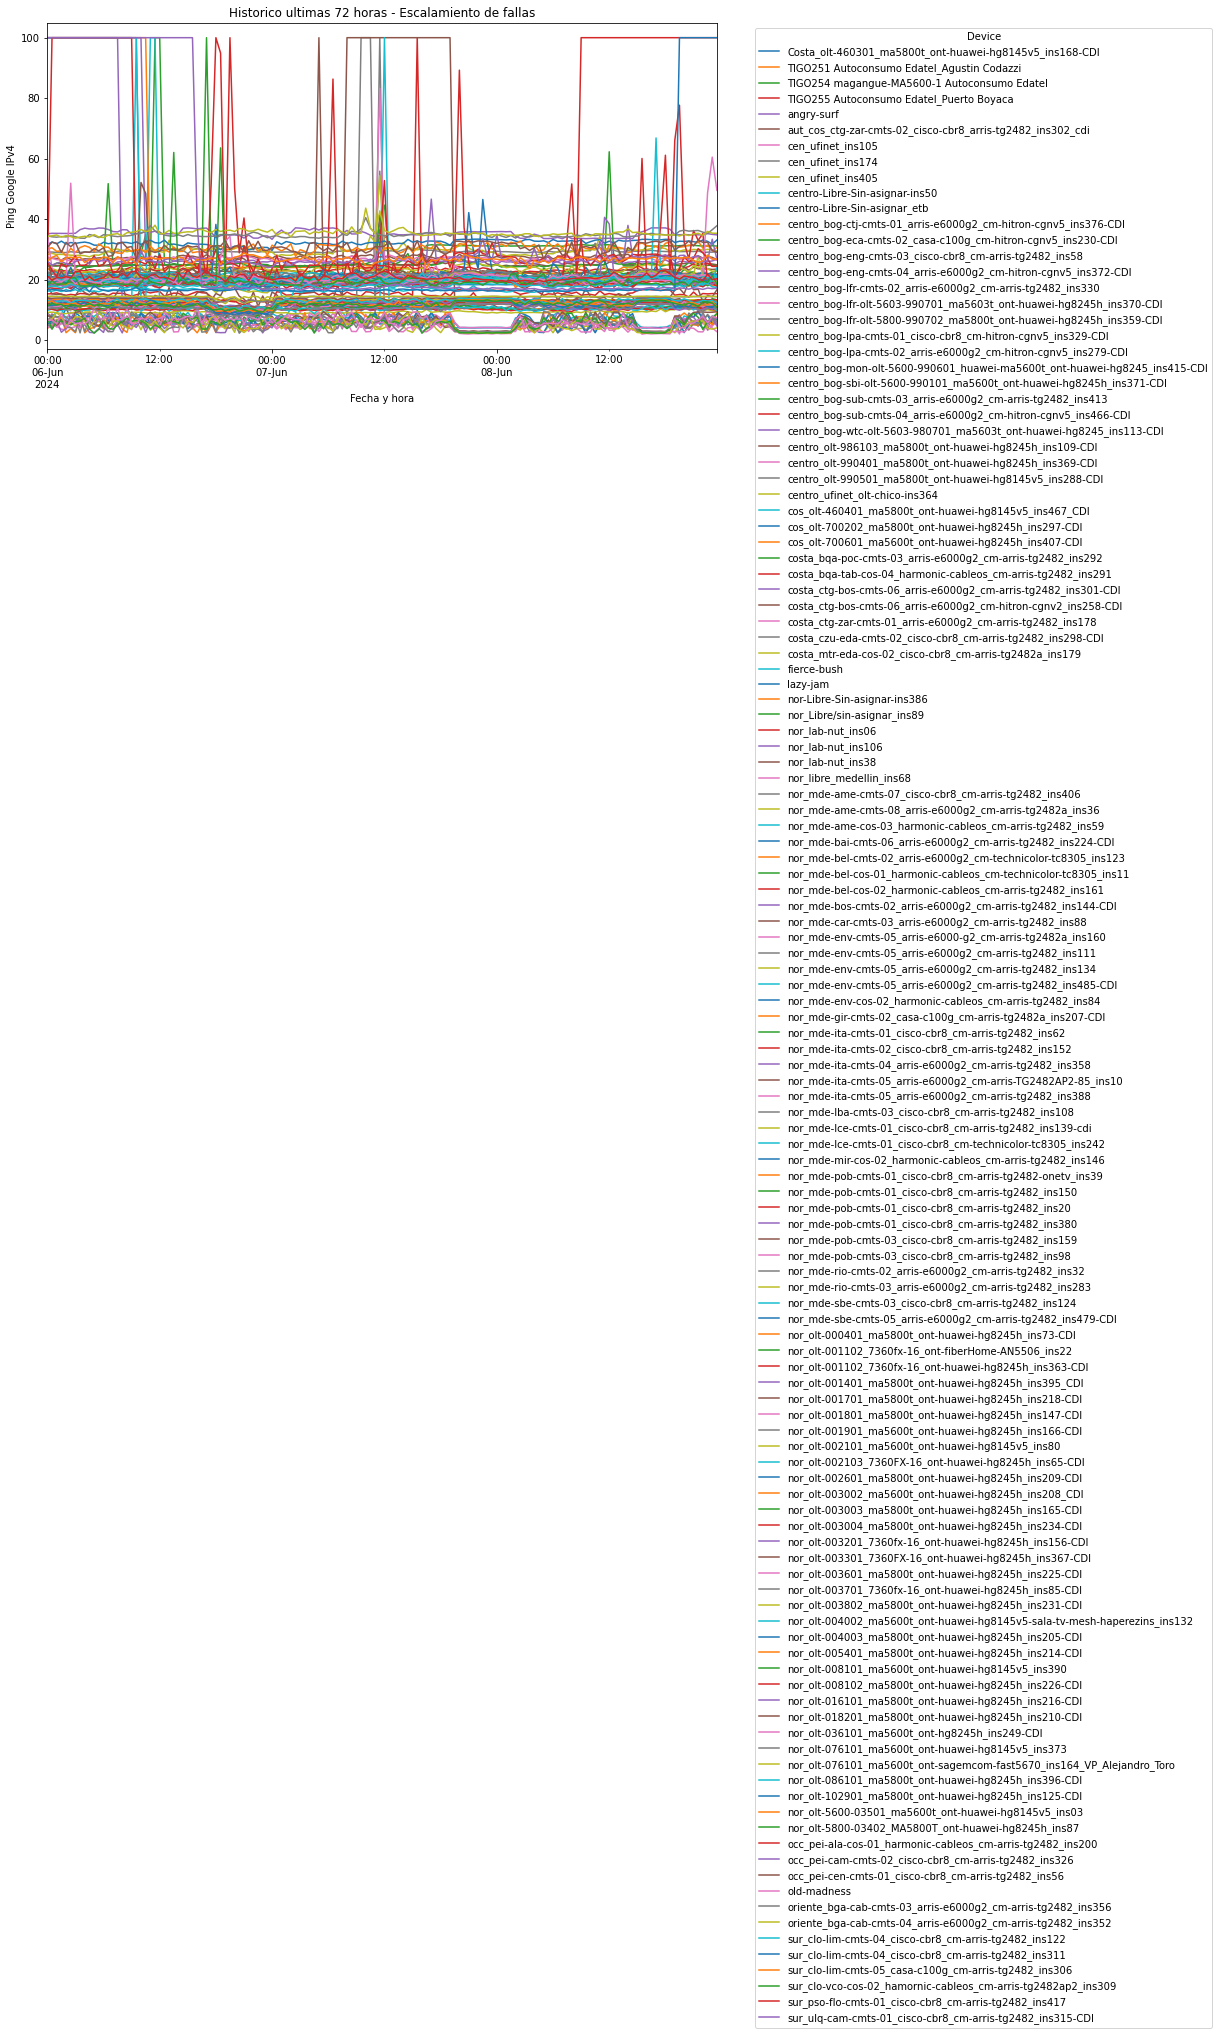

In [24]:
pivoted_df.plot(kind='line', figsize=(12, 6))  # Adjust figsize for better readability

# Optional: Customize the plot
plt.xlabel('Fecha y hora')  # Assuming your DataFrame has an index for time series
plt.ylabel('Ping Google IPv4')
plt.title('Historico ultimas 72 horas - Escalamiento de fallas')

plt.legend(title='Device', bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.legend(title='Columns')  # Display a legend for each time series

plt.show()

In [25]:
pivoted_df  = pivoted_df.interpolate()#Llenar los nan que se puedan con interpolacion y los demas con media
pivoted_df  = pivoted_df .fillna(pivoted_df .mean())

In [40]:
pivoted_df

DEVICE_NAME          TIGO153v2 Datacenter MedellÃÂ­n  \
FECHA                                                   
2024-04-20 08:30:00                         57.343667   
2024-04-20 09:00:00                         52.918333   
2024-04-20 09:30:00                         52.656125   
2024-04-20 10:00:00                         55.809778   
2024-04-20 10:30:00                         51.584778   
...                                               ...   
2024-04-23 06:00:00                         55.375000   
2024-04-23 06:30:00                         55.155000   
2024-04-23 07:00:00                         50.811778   
2024-04-23 07:30:00                         49.557000   
2024-04-23 08:00:00                         57.749000   

DEVICE_NAME          centro_bog-eca-cmts-01_cisco-cbr8_cm-hitron-cgnv5_ins219-CDI  \
FECHA                                                                               
2024-04-20 08:30:00                                             8.8156              
2024-04-20 09:00:00                                             8.5974              
2024-04-20 09:30:00                                             8.9605              
2024-04-20 10:00:00                                             8.7894              
2024-04-20 10:30:00                                             8.9486              
...                                                                ...              
2024-04-23 06:00:00                                           100.0000              
2024-04-23 06:30:00                                           100.0000              
2024-04-23 07:00:00                                           100.0000              
2024-04-23 07:30:00                                           100.0000              
2024-04-23 08:00:00                                           100.0000              

DEVICE_NAME          centro_bog-tim-cmts-08_arris-e6000g2_hitron-cgnv5_ins339-CDI  \
FECHA                                                                               
2024-04-20 08:30:00                                            9.90575              
2024-04-20 09:00:00                                            9.86220              
2024-04-20 09:30:00                                           10.16940              
2024-04-20 10:00:00                                            9.98180              
2024-04-20 10:30:00                                           10.58275              
...                                                                ...              
2024-04-23 06:00:00                                          100.00000              
2024-04-23 06:30:00                                          100.00000              
2024-04-23 07:00:00                                          100.00000              
2024-04-23 07:30:00                                          100.00000              
2024-04-23 08:00:00                                          100.00000              

DEVICE_NAME          centro_fac-fac3-cmts-01_arris_e6000g2-cm_hitron_cgnv5-ins157-CDI  \
FECHA                                                                                   
2024-04-20 08:30:00                                            10.9666                  
2024-04-20 09:00:00                                            10.7294                  
2024-04-20 09:30:00                                            10.5536                  
2024-04-20 10:00:00                                            10.8200                  
2024-04-20 10:30:00                                            10.3930                  
...                                                                ...                  
2024-04-23 06:00:00                                           100.0000                  
2024-04-23 06:30:00                                           100.0000                  
2024-04-23 07:00:00                                           100.0000                  
2024-04-23 07:30:00                                           100.0

In [26]:
from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler(feature_range=(0, 1))
#df_normalized = pd.DataFrame(scaler.fit_transform(pivoted_df))
df_normalized = pivoted_df
df_normalized.columns = pivoted_df.columns


In [27]:
df_normalized

DEVICE_NAME          Costa_olt-460301_ma5800t_ont-huawei-hg8145v5_ins168-CDI  \
FECHA                                                                          
2024-06-06 00:00:00                                          18.167444         
2024-06-06 00:30:00                                          18.169000         
2024-06-06 01:00:00                                          18.124400         
2024-06-06 01:30:00                                          18.127111         
2024-06-06 02:00:00                                          18.247222         
...                                                                ...         
2024-06-08 21:30:00                                          18.284667         
2024-06-08 22:00:00                                          18.318667         
2024-06-08 22:30:00                                          18.323444         
2024-06-08 23:00:00                                          18.276556         
2024-06-08 23:30:00                                          18.314000         

DEVICE_NAME          TIGO251 Autoconsumo Edatel_Agustin Codazzi  \
FECHA                                                             
2024-06-06 00:00:00                                   22.256750   
2024-06-06 00:30:00                                   22.329667   
2024-06-06 01:00:00                                   22.252125   
2024-06-06 01:30:00                                   22.299222   
2024-06-06 02:00:00                                   22.237750   
...                                                         ...   
2024-06-08 21:30:00                                   22.021444   
2024-06-08 22:00:00                                   22.039556   
2024-06-08 22:30:00                                   21.984625   
2024-06-08 23:00:00                                   22.051000   
2024-06-08 23:30:00                                   21.966375   

DEVICE_NAME          TIGO254 magangue-MA5600-1 Autoconsumo Edatel  \
FECHA                                                               
2024-06-06 00:00:00                                     24.539750   
2024-06-06 00:30:00                                     24.487000   
2024-06-06 01:00:00                                     24.453875   
2024-06-06 01:30:00                                     24.627556   
2024-06-06 02:00:00                                     24.483500   
...                                                           ...   
2024-06-08 21:30:00                                     31.195667   
2024-06-08 22:00:00                                     31.077250   
2024-06-08 22:30:00                                     31.091625   
2024-06-08 23:00:00                                     31.180500   
2024-06-08 23:30:00                                     31.072500   

DEVICE_NAME          TIGO255 Autoconsumo Edatel_Puerto Boyaca  angry-surf  \
FECHA                                                                       
2024-06-06 00:00:00                                 15.262556   35.143000   
2024-06-06 00:30:00                                 15.300375   35.288250   
2024-06-06 01:00:00                                 15.604333   35.267143   
2024-06-06 01:30:00                                 15.070444   35.239000   
2024-06-06 02:00:00                                 14.793125   35.245000   
...                                                       ...         ...   
2024-06-08 21:30:00                                 14.450333   34.796375   
2024-06-08 22:00:00                                 15.382750   34.779875   
2024-06-08 22:30:00                                 15.255111   35.188571   
2024-06-08 23:00:00                                 15.373222   34.941750   
2024-06-08 23:30:00                                 15.329571   34.780857   

DEVICE_NAME          aut_cos_ctg-zar-cmts-02_cisco-cbr8_arris-tg2482_ins302_cdi  \
FECHA                                                                             
2024-06-06 00:00:00  

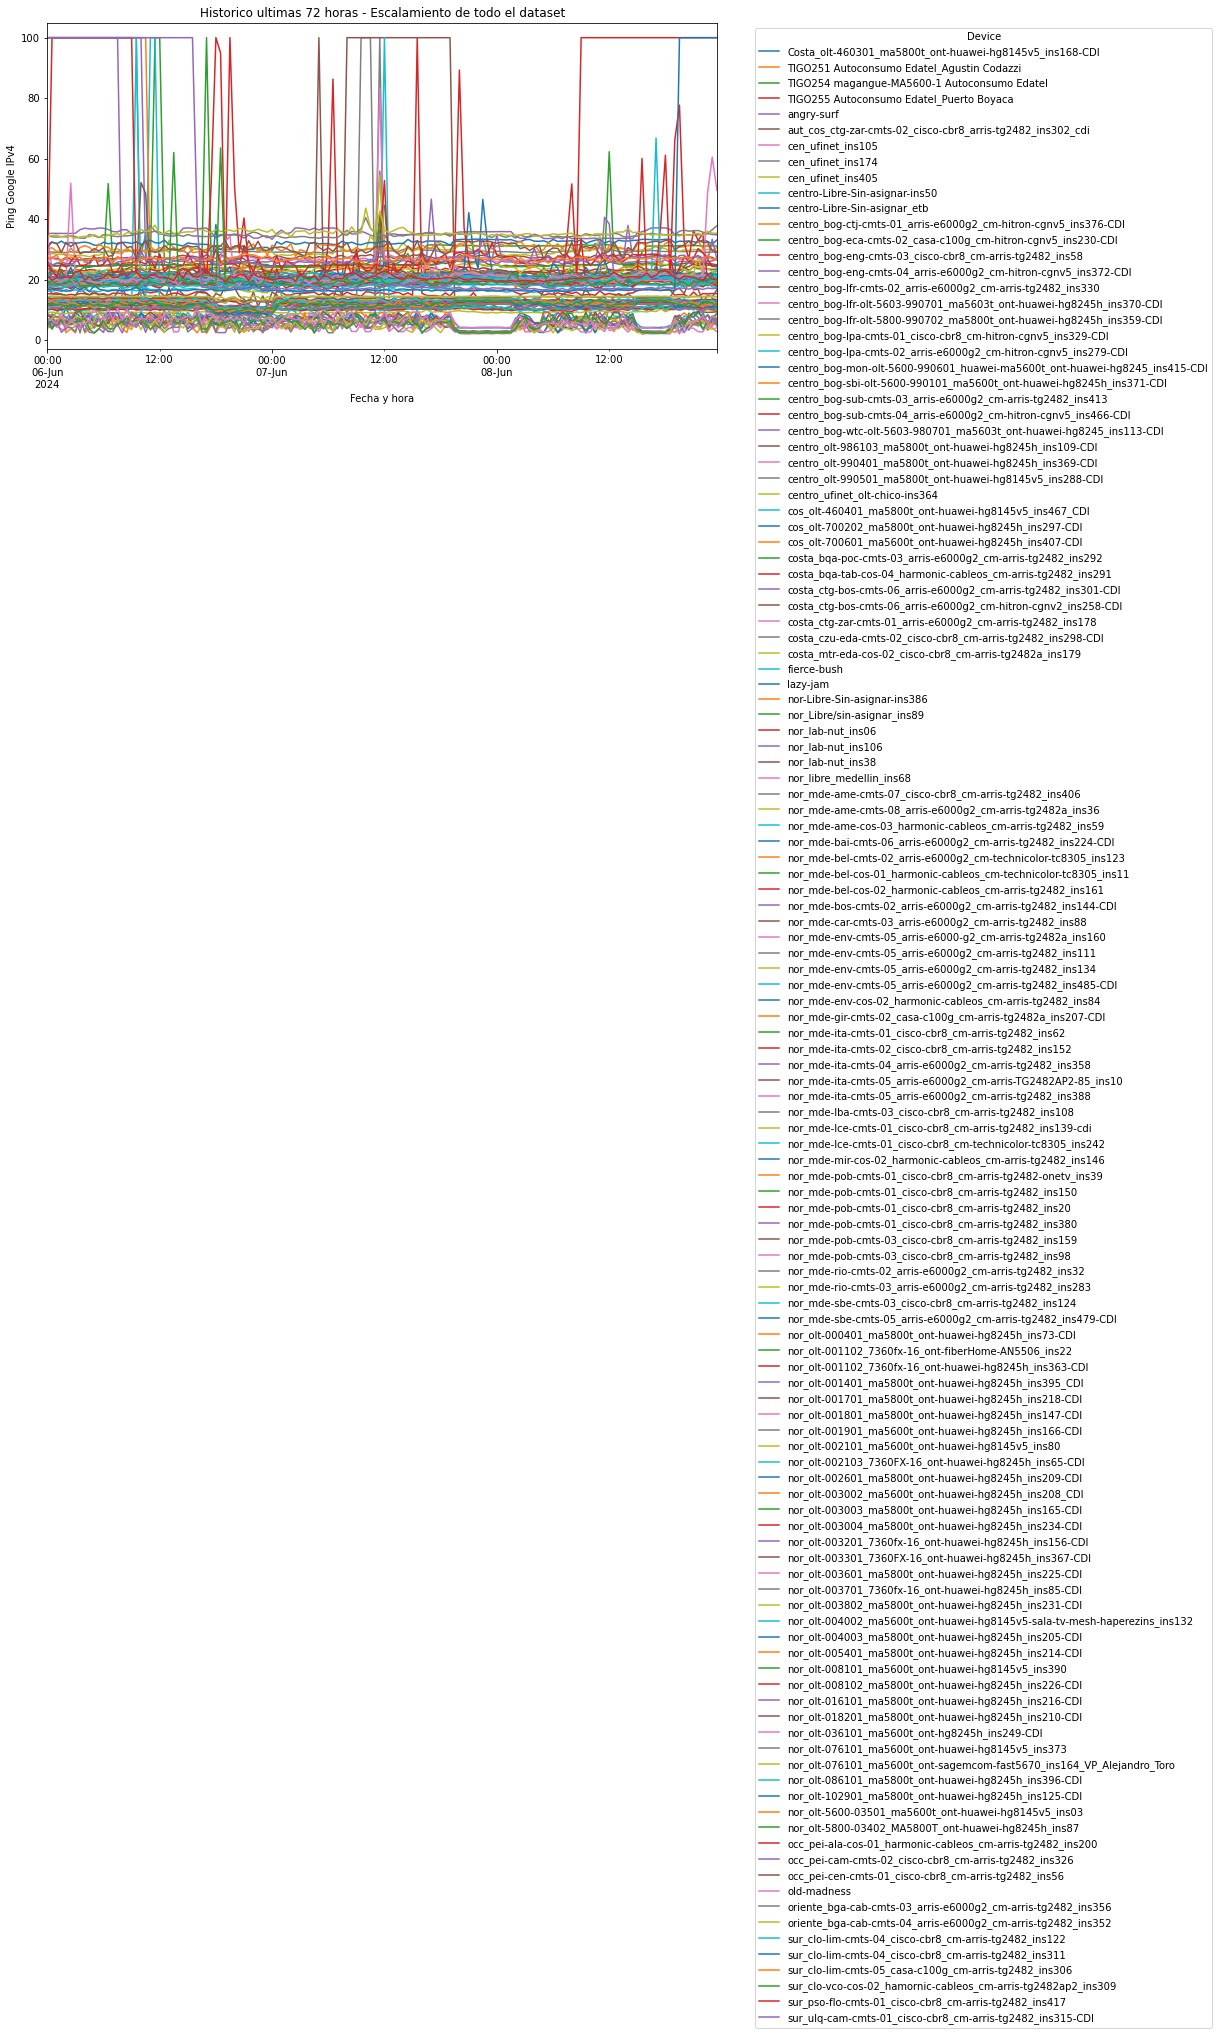

In [28]:
import matplotlib.pyplot as plt




df_normalized.plot(kind='line', figsize=(12, 6))  # Adjust figsize for better readability

# Optional: Customize the plot
plt.xlabel('Fecha y hora')  # Assuming your DataFrame has an index for time series
plt.ylabel('Ping Google IPv4')
plt.title('Historico ultimas 72 horas - Escalamiento de todo el dataset')

plt.legend(title='Device', bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.legend(title='Columns')  # Display a legend for each time series

plt.show()

In [29]:
X_df=df_normalized.transpose()
#X_df=pivoted_df.transpose()
X_df

FECHA                                               2024-06-06 00:00:00  \
DEVICE_NAME                                                               
Costa_olt-460301_ma5800t_ont-huawei-hg8145v5_in...            18.167444   
TIGO251 Autoconsumo Edatel_Agustin Codazzi                    22.256750   
TIGO254 magangue-MA5600-1 Autoconsumo Edatel                  24.539750   
TIGO255 Autoconsumo Edatel_Puerto Boyaca                      15.262556   
angry-surf                                                    35.143000   
...                                                                 ...   
sur_clo-lim-cmts-04_cisco-cbr8_cm-arris-tg2482_...            16.601600   
sur_clo-lim-cmts-05_casa-c100g_cm-arris-tg2482_...            26.027600   
sur_clo-vco-cos-02_hamornic-cableos_cm-arris-tg...            18.123600   
sur_pso-flo-cmts-01_cisco-cbr8_cm-arris-tg2482_...            21.170500   
sur_ulq-cam-cmts-01_cisco-cbr8_cm-arris-tg2482_...           100.000000   

FECHA                                               2024-06-06 00:30:00  \
DEVICE_NAME                                                               
Costa_olt-460301_ma5800t_ont-huawei-hg8145v5_in...            18.169000   
TIGO251 Autoconsumo Edatel_Agustin Codazzi                    22.329667   
TIGO254 magangue-MA5600-1 Autoconsumo Edatel                  24.487000   
TIGO255 Autoconsumo Edatel_Puerto Boyaca                      15.300375   
angry-surf                                                    35.288250   
...                                                                 ...   
sur_clo-lim-cmts-04_cisco-cbr8_cm-arris-tg2482_...            16.725600   
sur_clo-lim-cmts-05_casa-c100g_cm-arris-tg2482_...            27.350750   
sur_clo-vco-cos-02_hamornic-cableos_cm-arris-tg...            19.709000   
sur_pso-flo-cmts-01_cisco-cbr8_cm-arris-tg2482_...            19.783000   
sur_ulq-cam-cmts-01_cisco-cbr8_cm-arris-tg2482_...           100.000000   

FECHA                                               2024-06-06 01:00:00  \
DEVICE_NAME                                                               
Costa_olt-460301_ma5800t_ont-huawei-hg8145v5_in...            18.124400   
TIGO251 Autoconsumo Edatel_Agustin Codazzi                    22.252125   
TIGO254 magangue-MA5600-1 Autoconsumo Edatel                  24.453875   
TIGO255 Autoconsumo Edatel_Puerto Boyaca                      15.604333   
angry-surf                                                    35.267143   
...                                                                 ...   
sur_clo-lim-cmts-04_cisco-cbr8_cm-arris-tg2482_...            16.586250   
sur_clo-lim-cmts-05_casa-c100g_cm-arris-tg2482_...            28.016600   
sur_clo-vco-cos-02_hamornic-cableos_cm-arris-tg...            18.378400   
sur_pso-flo-cmts-01_cisco-cbr8_cm-arris-tg2482_...            20.675000   
sur_ulq-cam-cmts-01_cisco-cbr8_cm-arris-tg2482_...           100.000000   

FECHA                                               2024-06-06 01:30:00  \
DEVICE_NAME                                                               
Costa_olt-460301_ma5800t_ont-huawei-hg8145v5_in...            18.127111   
TIGO251 Autoconsumo Edatel_Agustin Codazzi                    22.299222   
TIGO254 magangue-MA5600-1 Autoconsumo Edatel                  24.627556   
TIGO255 Autoconsumo Edatel_Puerto Boyaca                      15.070444   
angry-surf                                                    35.239000   
...                                                                 ...   
sur_clo-lim-cmts-04_cisco-cbr8_cm-arris-tg2482_...            16.507600   
sur_clo-lim-cmts-05_casa-c100g_cm-arris-tg2482_...            25.771500   
sur_clo-vco-cos-02_hamornic-cableos_cm-arris-tg...            18.514250   
sur_pso-flo-cmts-01_cisco-cbr8_cm-arris-tg2482_...            20.480400   
sur_ulq-cam-cmts-01_cisco-cbr8_cm-arris-tg2482_...           100.000000   

FECHA                                               2024-06-06 02:00:00  \
DEVICE_NAME          

In [30]:
X = X_df.values

In [31]:
X

array([[ 18.16744444,  18.169     ,  18.1244    , ...,  18.32344444,
         18.27655556,  18.314     ],
       [ 22.25675   ,  22.32966667,  22.252125  , ...,  21.984625  ,
         22.051     ,  21.966375  ],
       [ 24.53975   ,  24.487     ,  24.453875  , ...,  31.091625  ,
         31.1805    ,  31.0725    ],
       ...,
       [ 18.1236    ,  19.709     ,  18.3784    , ...,  19.036     ,
         21.2926    ,  18.49775   ],
       [ 21.1705    ,  19.783     ,  20.675     , ...,  21.7444    ,
         19.9755    ,  20.24775   ],
       [100.        , 100.        , 100.        , ...,  17.184     ,
         17.00875   ,  17.124     ]])

In [32]:

elbow_data = []

maximo = 10
for n_clusters in range (2,maximo,1):   
    print(n_clusters) 
    
    km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=42,n_jobs=-1, metric = 'euclidean')
    y_pred = km.fit_predict(X)
    
    if n_clusters > 1:
        silueta =  silhouette_score(X, km.fit_predict(X))
    else:
        silueta = 1
    elbow_data.append((n_clusters, km.inertia_, silueta ))
    

df = pd.DataFrame(elbow_data, columns=['clusters', 'distance', 'silhouette'])

2
3
4
5
6
7
8
9


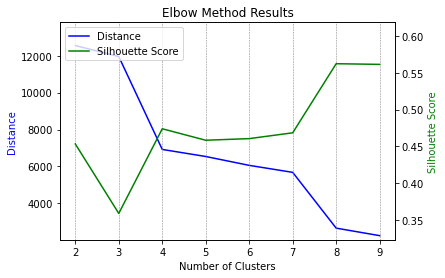

In [33]:

# Create the figure and axes
fig, ax1 = plt.subplots()

# Define secondary y-axis
ax2 = ax1.twinx()

# Plot 'distance' on primary y-axis (ax1)
ax1.plot(df['clusters'], df['distance'], 'b-', label='Distance')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Distance', color='b')

# Plot 'silhouette' on secondary y-axis (ax2)
ax2.plot(df['clusters'], df['silhouette'], 'g-', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='g')

# Set different scales for y-axes (optional)
# You can adjust the scale based on your data distribution
ax1.set_ylim(bottom=min(df['distance']) * 0.9, top=max(df['distance']) * 1.1)  # Adjust based on your data
ax2.set_ylim(bottom=min(df['silhouette']) * 0.9, top=max(df['silhouette']) * 1.1)  # Adjust based on your data

# Define cluster positions (assuming 'clusters' represent positions)
cluster_positions = df['clusters']

# Create vertical dotted grey lines at cluster positions
for cluster in cluster_positions:
  ax1.axvline(x=cluster, color='grey', linestyle='--', linewidth=0.5)

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Improve x-axis ticks for readability (optional)
ax1.xaxis.set_major_locator(MultipleLocator(1))  # Adjust based on your data

# Set title and show the plot
plt.title('Elbow Method Results')
plt.show()

In [34]:
km = TimeSeriesKMeans(n_clusters=8, verbose=False, random_state=42,n_jobs=-1, metric = 'euclidean').fit(X)


df_cluster = pd.DataFrame(list(zip(pivoted_df.columns, km.labels_)), columns=['device', 'cluster'])

centers = km.cluster_centers_

zz = centers[0]

clasificados_dict = {}
for i in list(set(df_cluster['cluster'])):
    names = list(df_cluster[df_cluster['cluster']==i]['device'])
    
    clasificados_dict[i]=pivoted_df[names]
    
    clasificados_dict[i]['PATRON']=centers[i]

<ipython-input-34-05927a0cc677>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clasificados_dict[i]['PATRON']=centers[i]
<ipython-input-34-05927a0cc677>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clasificados_dict[i]['PATRON']=centers[i]
<ipython-input-34-05927a0cc677>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [35]:
(clasificados_dict.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7])

In [36]:
def grafica_clusters(data, title):
    other_cols = [col for col in data.columns if col != "PATRON"]  # Get other column names
    
    # Define color scheme (adjust lightness for other series)
    colors = ['lightgray' for _ in other_cols] + ['blue']  # Blue for "PATRON"
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot other series with lighter shades
    for col, color in zip(other_cols, colors):
      data[col].plot(ax=ax, color=color, alpha=0.7, label=col)  # Adjust alpha for transparency
    
    
    ax.set_xlabel("Fecha y Hora")
    ax.set_ylabel("Ping Google IPv4")
    ax.set_title(title)
    
    # Add legend
    ax.legend()
    plt.legend(title='Device', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show() 

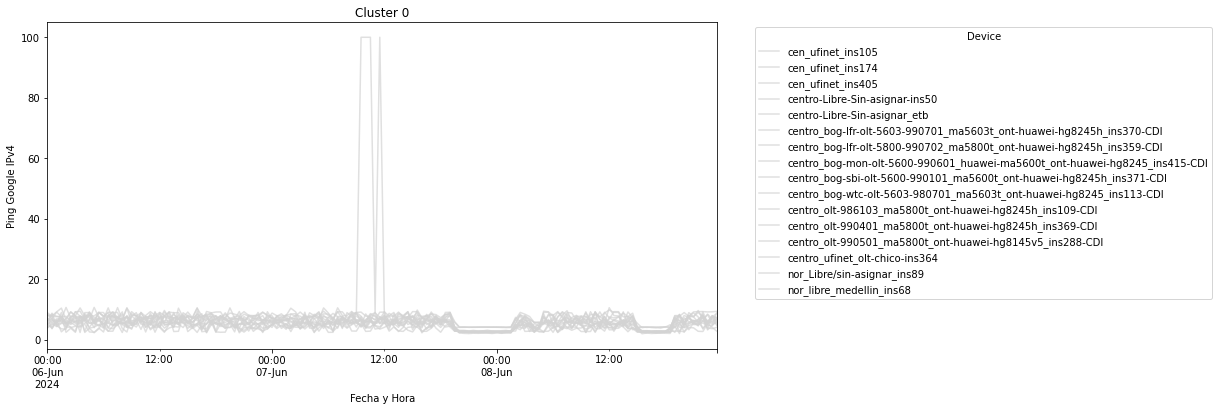

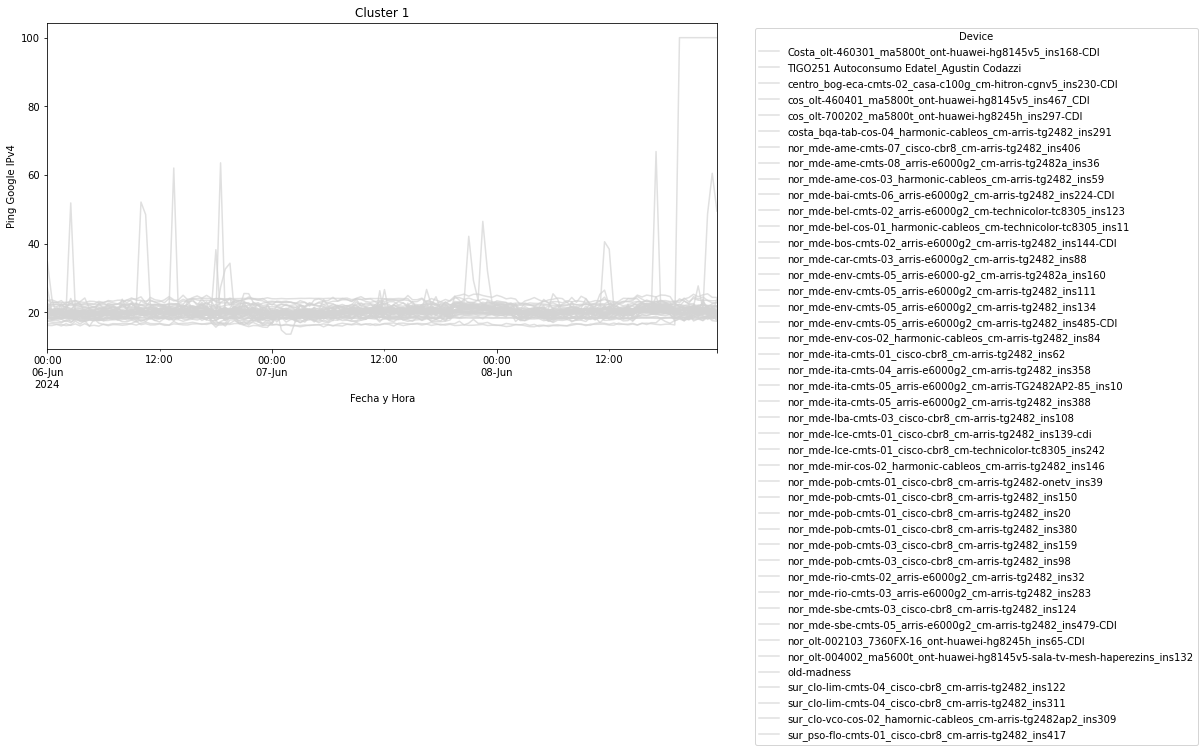

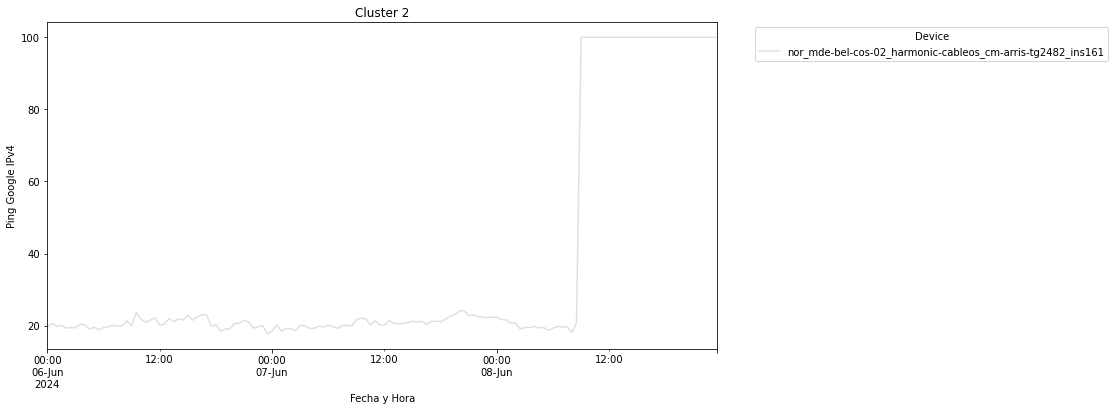

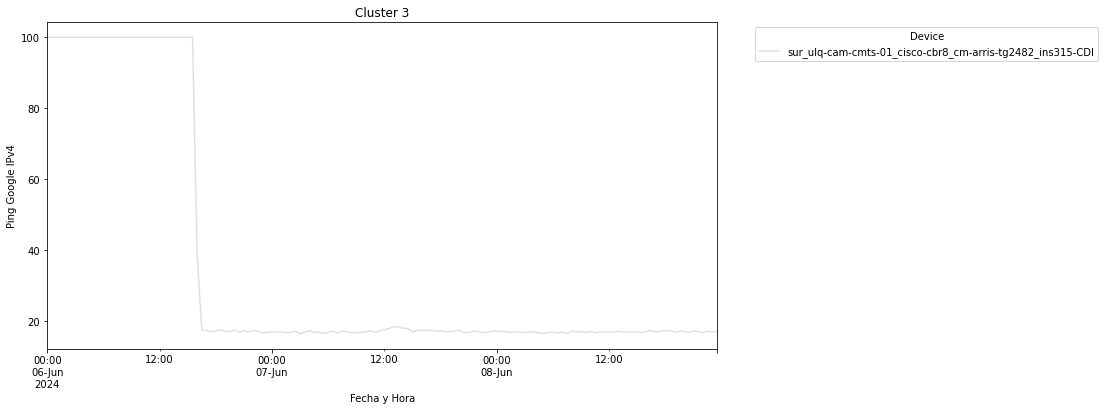

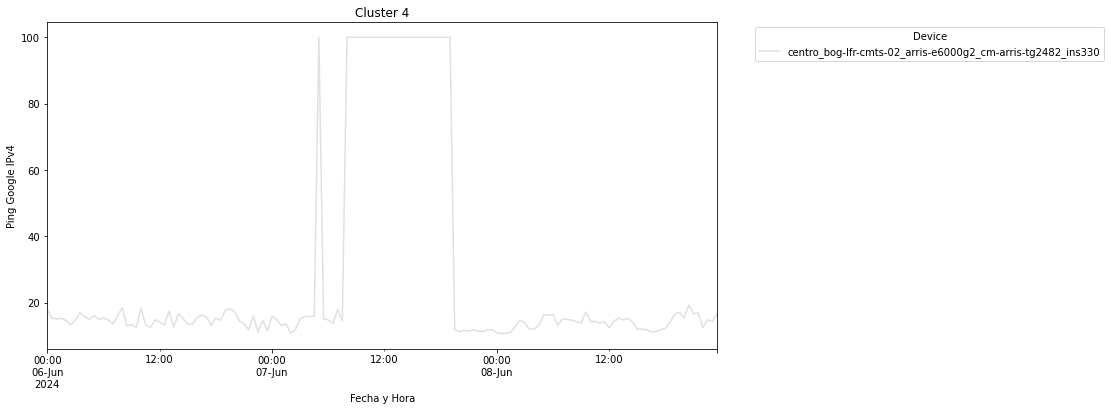

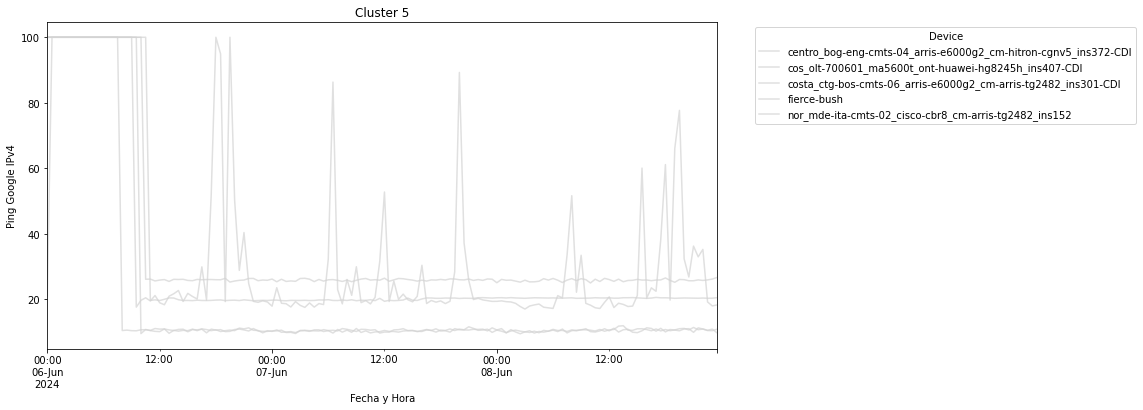

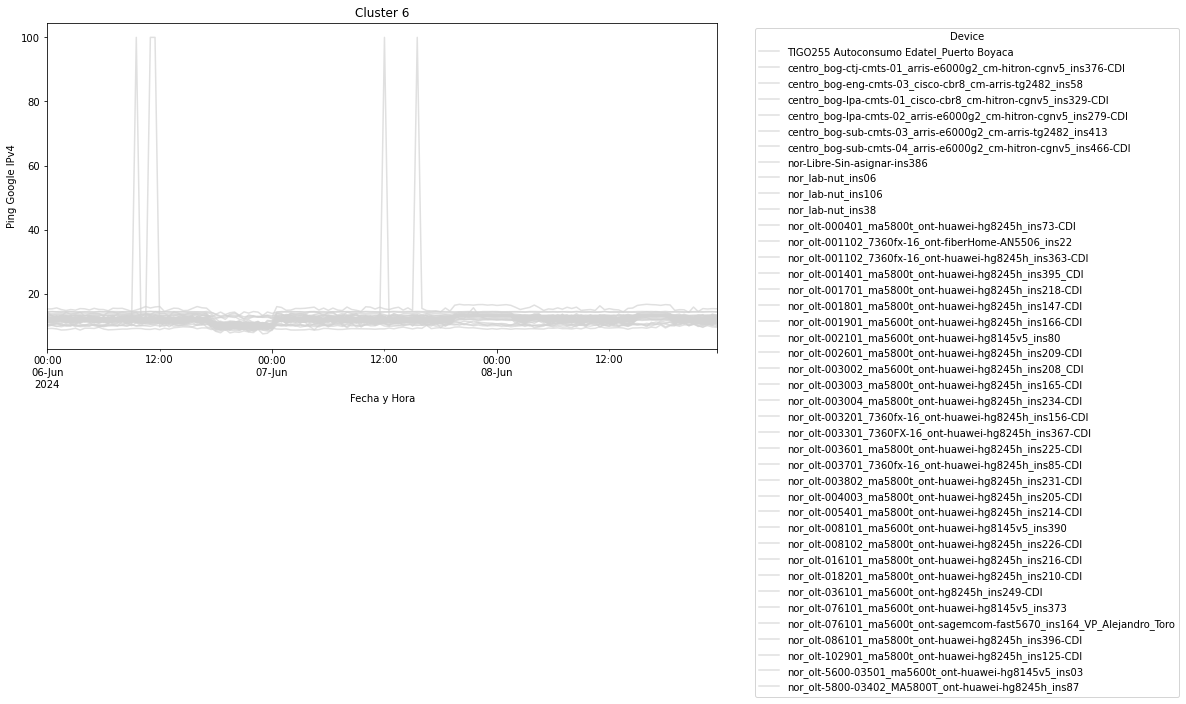

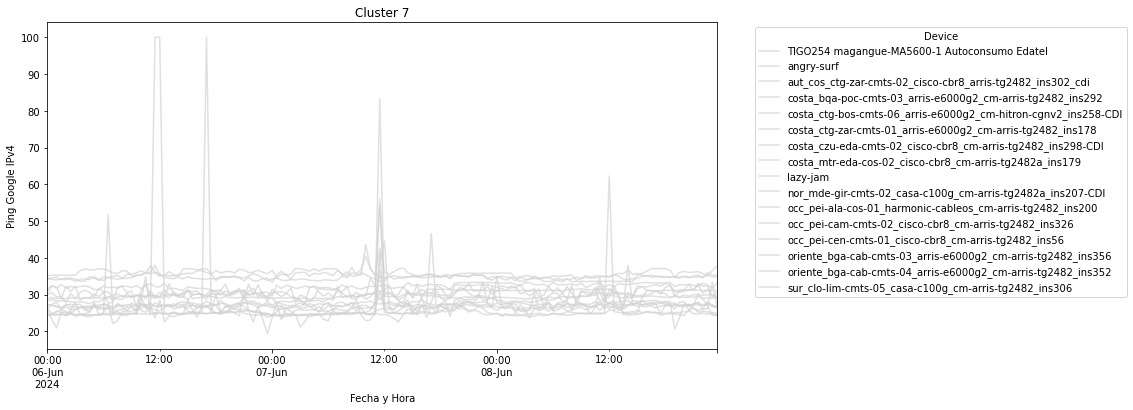

In [37]:
grafica_clusters(clasificados_dict[0], 'Cluster 0')

grafica_clusters(clasificados_dict[1], 'Cluster 1')

grafica_clusters(clasificados_dict[2], 'Cluster 2')

grafica_clusters(clasificados_dict[3], 'Cluster 3')
    
grafica_clusters(clasificados_dict[4], 'Cluster 4')

grafica_clusters(clasificados_dict[5], 'Cluster 5')

grafica_clusters(clasificados_dict[6], 'Cluster 6')
grafica_clusters(clasificados_dict[7], 'Cluster 7')

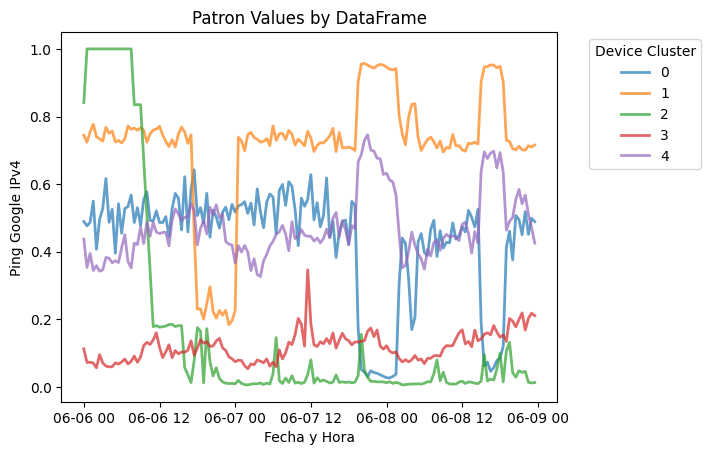

In [26]:
data_dict = clasificados_dict

# Create a new figure and axes
fig, ax = plt.subplots()

# Loop through each dictionary key-value pair
colors = plt.cm.tab10.colors  # Define a colormap for multiple colors

alpha_value = 0.7  # Adjust alpha value for translucency (0 to 1)
line_width = 2  # Adjust line width (default is 1.5)

for key, df in data_dict.items():
  # Extract 'patron' column and plot with a unique color, alpha, and line width
  color = colors[list(data_dict.keys()).index(key)]  # Assign color based on key order
  ax.plot(df['PATRON'], label=key, color=color, alpha=alpha_value, linewidth=line_width)

# Add labels and title
ax.set_xlabel('Fecha y Hora')
ax.set_ylabel('Ping Google IPv4')
ax.set_title('Patron Values by DataFrame')

# Add Legend
plt.legend()
plt.legend(title='Device Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
# Show the plot
plt.show()


In [31]:
df_cluster

device  cluster
0   Costa_olt-460301_ma5800t_ont-huawei-hg8145v5_i...        0
1          TIGO251 Autoconsumo Edatel_Agustin Codazzi        0
2        TIGO254 magangue-MA5600-1 Autoconsumo Edatel        0
3            TIGO255 Autoconsumo Edatel_Puerto Boyaca        3
4         TIGO27 Paola Helena PatiÃÂ±o BogotÃÂ¡ Etb        3
..                                                ...      ...
89  occ_pei-ala-cos-01_harmonic-cableos_cm-arris-t...        1
90  occ_pei-cen-cmts-01_cisco-cbr8_cm-arris-tg2482...        0
91                                        old-madness        1
92  oriente_bga-cab-cmts-03_arris-e6000g2_cm-arris...        0
93  sur_clo-lim-cmts-04_cisco-cbr8_cm-arris-tg2482...        1

[94 rows x 2 columns]